## Задание 
1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [74]:
import pandas as pd
from scipy import stats
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [93]:
# функция для бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
       
    return { 'p_value': p_value}

Считаем данные и посмотрим на них.

In [41]:
df = pd.read_csv('hw_bootstrap.csv', sep = ';', index_col=0, decimal=',')

In [42]:
df.head(3)

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


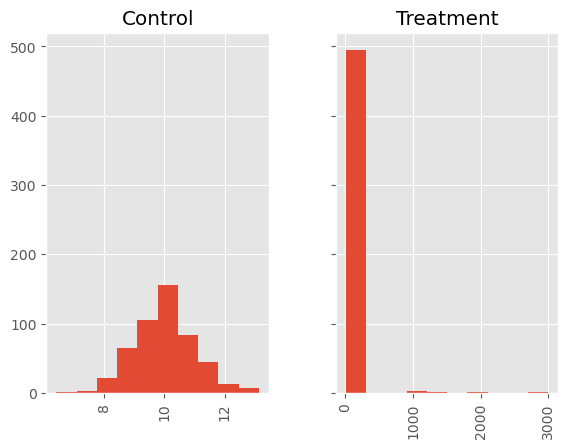

In [79]:
df.hist('value', by='experimentVariant', sharey=True);

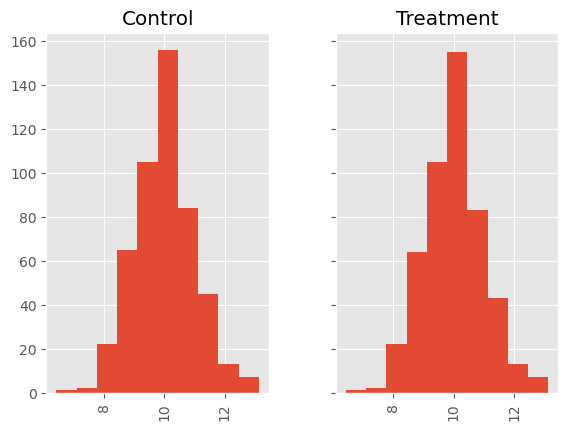

In [82]:
# посмотрим на распределения без учета выбросов
df.query('value < 1000').hist('value', by='experimentVariant', sharex=True, sharey=True);

Создадим словарь pvalues и занесем туда p-value 3-х разных тестов.

In [45]:
pvalues = {}
pvalues['ttest'] = stats.ttest_ind(df.value[df.experimentVariant == 'Control'], 
                          df.value[df.experimentVariant == 'Treatment']).pvalue

In [46]:
pvalues['utest'] = stats.mannwhitneyu(df.value[df.experimentVariant == 'Control'], 
                                      df.value[df.experimentVariant == 'Treatment']).pvalue

In [94]:
# посчитаем бутстрепом несколько раз, чтобы исключить влияние случайности
pvalues['bootstrap_mean'] = []

for i in range(10):
    boot_i = get_bootstrap(df.value[df.experimentVariant == 'Control'], 
                           df.value[df.experimentVariant == 'Treatment'],
                           statistic = np.mean)['p_value']
    pvalues['bootstrap_mean'].append(boot_i)


In [95]:
# посчитаем бутстрепом несколько раз, чтобы исключить влияние случайности
pvalues['bootstrap_median'] = []

for i in range(10):
    boot_i = get_bootstrap(df.value[df.experimentVariant == 'Control'], 
                           df.value[df.experimentVariant == 'Treatment'],
                           statistic = np.median)['p_value']
    pvalues['bootstrap_median'].append(boot_i)


In [96]:
pvalues

{'ttest': 0.038437593613498765,
 'utest': 0.8592148582485579,
 'bootstrap': 0.04484003537144897,
 'bootstrap_median': [0.9973057748082728,
  0.9774091453981528,
  0.9388089703450745,
  0.9647101557794976,
  0.9346098165936145,
  0.9791225632921777,
  0.961683779226438,
  0.9101991671065478,
  0.9889967500651922,
  0.9639798121940565],
 'bootstrap_mean': [0.038261161972190996,
  0.03985846151633656,
  0.035099187691965995,
  0.03726673652677242,
  0.03963661113608292,
  0.04121673063978127,
  0.03772306051846879,
  0.039778066765551345,
  0.03632449279717762,
  0.031200774166092096]}

## Выводы

t-test и бутстрап для среднего дают показывают значимые различия, но на эти результаты существенно влияют выбросы в тестовой группе. Таким образом, методы, использующие сравнение средних не подходят.  
  
Тест Манна-Уитни и бутстрап для медианы не показывают значимых различий, и это подтверждается графиками распределений. Эти методы не чувствительны к выбросам и в данной задаче показывают более адекватные результаты.